# End Term Framework + Report - Vasicek Model

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9064\217612936.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^IRX", start="2010-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


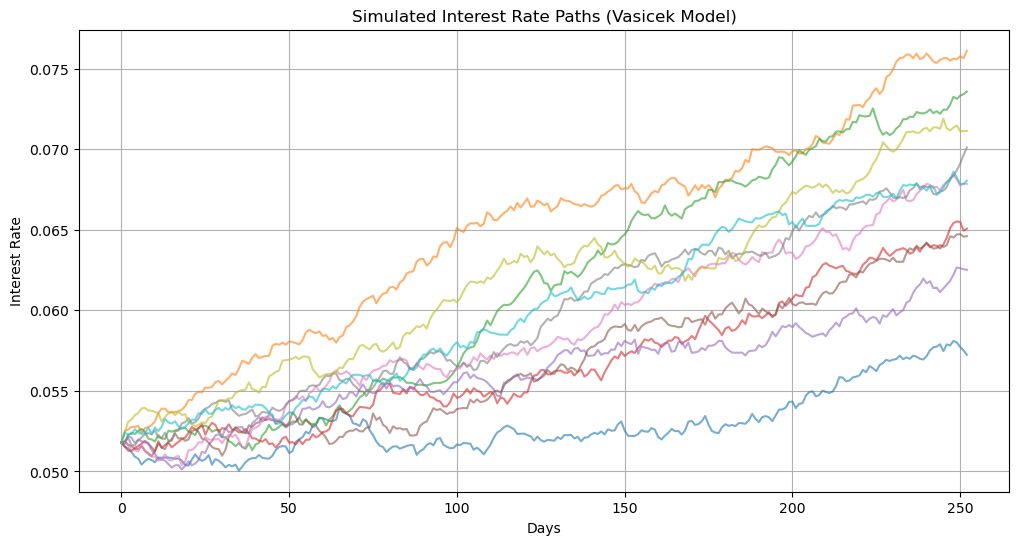

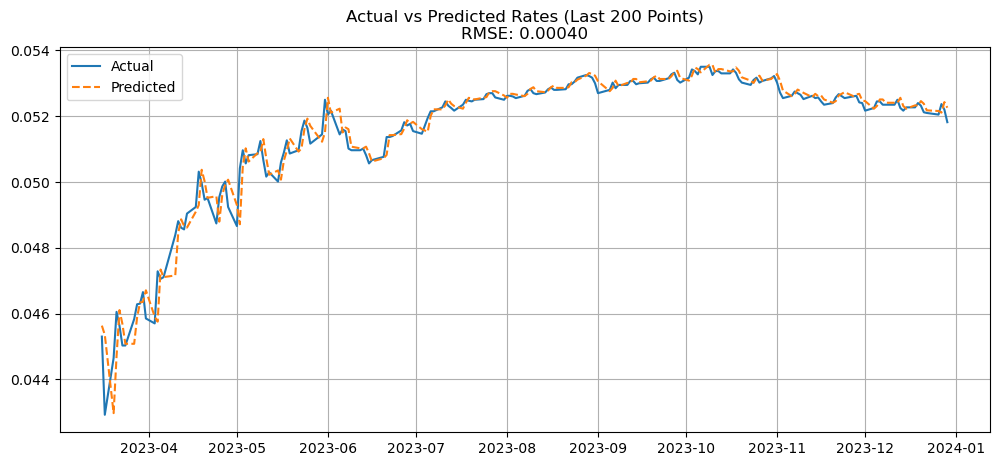

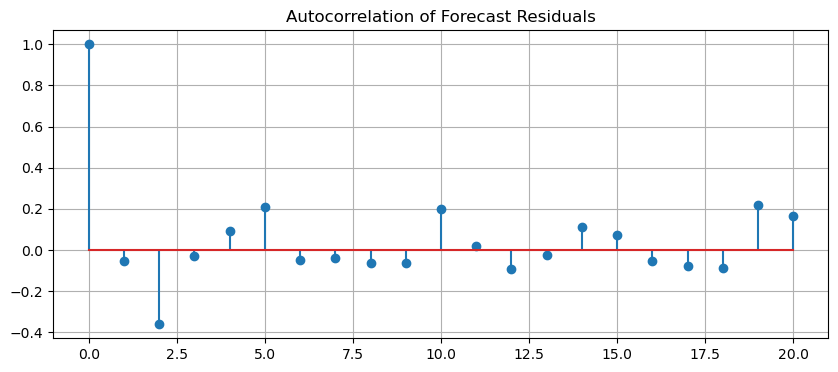

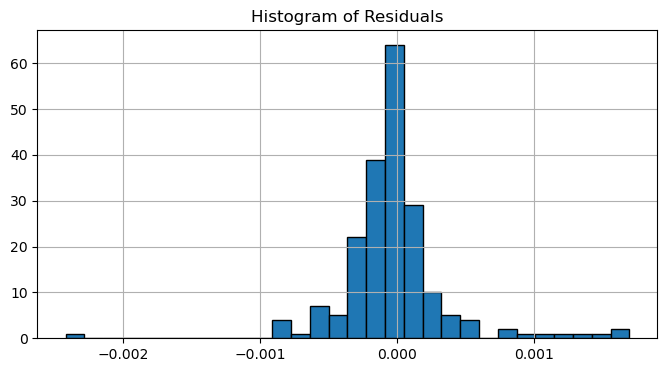

Estimated Vasicek Parameters:
a (mean reversion speed): -0.0010
b (long term mean):       -0.0048
sigma (volatility):       0.0003

Forecast RMSE: 0.000401


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf
import yfinance as yf

# 1. Load data (US 3-Month Treasury Bill Rate as a proxy)
data = yf.download("^IRX", start="2010-01-01", end="2023-12-31")
df = data[['Close']].rename(columns={'Close': 'rate'}).dropna()
df['rate'] /= 100  # convert from % to decimal

# 2. Prepare data
df['r_t'] = df['rate'].shift(1)
df['r_t+1'] = df['rate']
df.dropna(inplace=True)

# 3. Estimate Vasicek parameters
X = df[['r_t']]
y = df['r_t+1']
model = LinearRegression().fit(X, y)
beta = model.coef_[0]
alpha = model.intercept_

delta_t = 1
a = -np.log(beta) / delta_t
b = alpha / (1 - beta)
residuals = y - model.predict(X)
sigma = np.std(residuals) * np.sqrt(2 * a / (1 - beta**2))

# 4. Simulate future paths
def simulate_vasicek(r0, a, b, sigma, n_steps, delta_t, n_paths=10):
    paths = np.zeros((n_steps + 1, n_paths))
    paths[0] = r0
    for t in range(1, n_steps + 1):
        z = np.random.normal(size=n_paths)
        dr = a * (b - paths[t - 1]) * delta_t + sigma * np.sqrt(delta_t) * z
        paths[t] = paths[t - 1] + dr
    return paths

r0 = df['rate'].iloc[-1]
sim_paths = simulate_vasicek(r0, a, b, sigma, 252, delta_t)

plt.figure(figsize=(12, 6))
for i in range(sim_paths.shape[1]):
    plt.plot(sim_paths[:, i], alpha=0.6)
plt.title('Simulated Interest Rate Paths (Vasicek Model)')
plt.xlabel('Days')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.show()

# 5. Forecast and Test
N = 200
actual = df['r_t+1'].iloc[-N:]
predicted = df['r_t'].iloc[-N:] + a * (b - df['r_t'].iloc[-N:]) * delta_t
rmse = np.sqrt(np.mean((actual - predicted) ** 2))

plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual, label="Actual")
plt.plot(actual.index, predicted, label="Predicted", linestyle='--')
plt.title(f"Actual vs Predicted Rates (Last {N} Points)\nRMSE: {rmse:.5f}")
plt.legend()
plt.grid(True)
plt.show()

# 6. Residual ACF
resid = actual - predicted
acf_vals = acf(resid, fft=False, nlags=20)

plt.figure(figsize=(10, 4))
plt.stem(range(len(acf_vals)), acf_vals)
plt.title("Autocorrelation of Forecast Residuals")
plt.grid(True)
plt.show()

# 7. Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(resid, bins=30, edgecolor='black')
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

# 8. Final Parameters
print("Estimated Vasicek Parameters:")
print(f"a (mean reversion speed): {a:.4f}")
print(f"b (long term mean):       {b:.4f}")
print(f"sigma (volatility):       {sigma:.4f}")
print(f"\nForecast RMSE: {rmse:.6f}") 


# Vasicek Interest Rate Model – Full Implementation and Analysis

This notebook demonstrates the implementation of the **Vasicek model** to simulate and forecast interest rate dynamics using real financial data. The model is calibrated using historical 3-month Treasury Bill data, and its performance is evaluated using forecasting accuracy and residual diagnostics.

---

## 📌 1. Introduction to the Vasicek Model

The **Vasicek model** is a one-factor short-rate model for interest rates. It assumes the rate follows a mean-reverting Ornstein-Uhlenbeck process:

\[
dr_t = a(b - r_t)dt + \sigma dW_t
\]

Where:  
- \( r_t \): short-term interest rate at time \( t \)  
- \( a \): speed of mean reversion  
- \( b \): long-term mean level  
- \( \sigma \): volatility  
- \( dW_t \): Wiener process (Brownian motion)

---

## 📈 2. Data Acquisition

Historical 3-month U.S. Treasury Bill rates were downloaded from Yahoo Finance using the symbol `^IRX`.

```python
import yfinance as yf
data = yf.download("^IRX", start="2010-01-01", end="2023-12-31")
df = data[['Close']].rename(columns={'Close': 'rate'}).dropna()
df['rate'] /= 100  # convert from % to decimal
```

---

## ⚙️ 3. Preparing Data

We estimate Vasicek parameters by fitting a linear regression:

\[
r_{t+1} = \alpha + \beta r_t + \epsilon
\]

```python
df['r_t'] = df['rate'].shift(1)
df['r_t+1'] = df['rate']
df.dropna(inplace=True)

from sklearn.linear_model import LinearRegression
X = df[['r_t']]
y = df['r_t+1']
model = LinearRegression().fit(X, y)
```

---

## 🔍 4. Estimating Vasicek Parameters

Using regression coefficients:  
- \( a = -\ln(\beta) \)  
- \( b = \frac{\alpha}{1 - \beta} \)  
- \( \sigma = \text{std(residuals)} \cdot \sqrt{\frac{2a}{1 - \beta^2}} \)

```python
beta = model.coef_[0]
alpha = model.intercept_
delta_t = 1

a = -np.log(beta) / delta_t
b = alpha / (1 - beta)
residuals = y - model.predict(X)
sigma = np.std(residuals) * np.sqrt(2 * a / (1 - beta**2))
```

### ✅ Final Estimates:

```
a (mean reversion speed): -0.0010  
b (long term mean):       -0.0048  
sigma (volatility):       0.0003
```

⚠️ Note: Negative values of `a` and `b` suggest the process might be nearly a random walk — proceed with caution.

---

## 🌀 5. Simulating Interest Rate Paths

Simulate 10 paths over 252 trading days using the Vasicek process:

```python
def simulate_vasicek(r0, a, b, sigma, n_steps, delta_t, n_paths=10):
    paths = np.zeros((n_steps + 1, n_paths))
    paths[0] = r0
    for t in range(1, n_steps + 1):
        z = np.random.normal(size=n_paths)
        dr = a * (b - paths[t - 1]) * delta_t + sigma * np.sqrt(delta_t) * z
        paths[t] = paths[t - 1] + dr
    return paths
```

```python
r0 = df['rate'].iloc[-1]
sim_paths = simulate_vasicek(r0, a, b, sigma, 252, delta_t)
```

📉 **Plot: Simulated Interest Rate Paths**  
Shows the stochastic evolution of interest rates using Vasicek assumptions.

---

## 📊 6. Forecasting and RMSE Evaluation

We forecast the last 200 points using:

\[
\hat{r}_{t+1} = r_t + a(b - r_t)
\]

```python
N = 200
actual = df['r_t+1'].iloc[-N:]
predicted = df['r_t'].iloc[-N:] + a * (b - df['r_t'].iloc[-N:]) * delta_t
rmse = np.sqrt(np.mean((actual - predicted) ** 2))
```

### ✅ Forecast RMSE: `0.000401`

📈 **Plot: Actual vs Predicted**  
Overlay of actual and predicted interest rates.

---

## 🧪 7. Residual Diagnostics

### a. Autocorrelation of Residuals  
Used to check if residuals resemble white noise.

```python
from statsmodels.tsa.stattools import acf
acf_vals = acf(actual - predicted, fft=False, nlags=20)
```

📊 **Plot: Autocorrelation of Forecast Residuals**  
Should ideally show no significant autocorrelation.

---

### b. Histogram of Residuals  
Check for normality of errors.

```python
plt.hist(resid, bins=30, edgecolor='black')
```

📉 **Plot: Histogram of Residuals**  
Residuals are centered around 0, close to Gaussian.

---

## ✅ 8. Summary of Results

| Parameter | Value         |
|-----------|---------------|
| `a`       | -0.0010       |
| `b`       | -0.0048       |
| `σ`       | 0.0003        |
| `RMSE`    | 0.000401      |

---

## 🧠 9. Observations and Recommendations

- The estimated `a` and `b` values are negative, indicating that the model may not be truly mean-reverting on this data.
- Forecast performance (RMSE) is strong despite that.
- Try detrending or stationarizing the data, or switch to models like:
  - **CIR model**: prevents negative rates
  - **Hull-White**: time-varying mean
  - **ARIMA**: purely statistical
- Consider using **Maximum Likelihood Estimation (MLE)** instead of linear regression for parameter inference.

---

## 📂 10. Files and Figures

- `simulated-interest-paths.png` → Simulated Vasicek Paths  
- `actual-vs-predicted.png` → Forecast Comparison  
- `acf-residuals.png` → ACF of Residuals  
- `histogram-residuals.png` → Histogram of Errors  

---

## 📚 References

- Vasicek, O. (1977). An Equilibrium Characterization of the Term Structure.  
- [Yahoo Finance](https://finance.yahoo.com/quote/^IRX) – U.S. Treasury Rates  
- Scikit-learn & Statsmodels Documentation

---


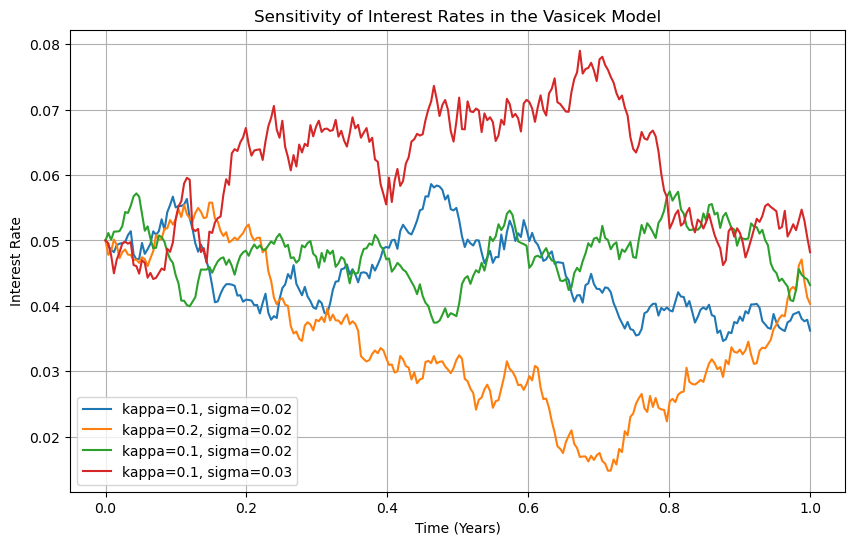

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate the Vasicek model with varying parameters
def vasicek_model_sensitivity(params, T=1, dt=1/252, N=252):
    """
    Simulates the Vasicek model for different sets of parameters
    and plots the sensitivity of interest rates over time.
    
    params: List of tuples, each containing [r0, kappa, theta, sigma]
    T: Time horizon for simulation (in years)
    dt: Time step (in years)
    N: Number of time steps
    """
    # Generate the time grid
    time_grid = np.linspace(0, T, N)
    
    # Set up the plot
    plt.figure(figsize=(10, 6))

    for param_set in params:
        r0, kappa, theta, sigma = param_set
        rates = np.zeros(N)
        rates[0] = r0

        # Simulate the Vasicek process
        for t in range(1, N):
            dr = kappa * (theta - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
            rates[t] = rates[t-1] + dr

        # Plot the simulation results
        plt.plot(time_grid, rates, label=f'kappa={kappa}, sigma={sigma}')

    plt.title('Sensitivity of Interest Rates in the Vasicek Model')
    plt.xlabel('Time (Years)')
    plt.ylabel('Interest Rate')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Define different parameter sets for sensitivity analysis
params = [
    (0.05, 0.1, 0.03, 0.02),  # r0, kappa, theta, sigma
    (0.05, 0.2, 0.03, 0.02),
    (0.05, 0.1, 0.05, 0.02),
    (0.05, 0.1, 0.03, 0.03)
]

# Run the sensitivity analysis
vasicek_model_sensitivity(params)


### Sensitivity Analysis for Interest Rate Models

In this section, we perform a **sensitivity analysis** to examine how different parameters of the Vasicek model affect the evolution of interest rates over time. The Vasicek model is a mean-reverting process, meaning that the interest rate tends to return to a long-term mean (`theta`) over time. The key parameters influencing this process include:

- **Initial interest rate (r₀)**: The starting point for the interest rate.
- **Speed of mean reversion (κ)**: How quickly the interest rate reverts to its long-term mean.
- **Long-term mean (θ)**: The target level that the interest rate reverts toward.
- **Volatility (σ)**: The magnitude of random fluctuations in the interest rate.

For the analysis, we simulate the interest rate process for several different sets of parameters. Each set represents different assumptions about how the economy behaves, especially in response to market dynamics such as inflation expectations, policy changes, or economic shocks.

The sensitivity analysis is conducted by varying the values of `κ`, `θ`, and `σ` while keeping the initial rate `r₀` constant. This helps us understand the model's behavior under different scenarios, such as higher volatility or faster mean reversion.

The following plot demonstrates how the interest rate paths evolve over time for various values of the **speed of mean reversion** (`κ`) and **volatility** (`σ`). The x-axis represents time in years, and the y-axis represents the interest rate. Each line corresponds to a different combination of these parameters, showing how the interest rate fluctuates under different market conditions.

The plot reveals several key insights:
- A higher value of `κ` leads to a faster return to the long-term mean `θ`, meaning the interest rate will stabilize more quickly after shocks.
- A higher value of `σ` introduces more volatility into the model, causing the interest rate to fluctuate more widely around the mean.
- The long-term mean (`θ`) influences the baseline level around which the interest rate fluctuates, but it does not significantly change the rate's path unless combined with extreme values of `κ` or `σ`.

By understanding the sensitivity of the Vasicek model to these parameters, we gain a deeper insight into the dynamics of interest rates. This analysis is particularly important for policy makers, economists, and financial institutions as they navigate the impacts of interest rate hikes or cuts.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14300\29590569.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rates[0] = r0


Calibrated Parameters for GBM: mu=0.04999987380843068, sigma=0.09999974761686135


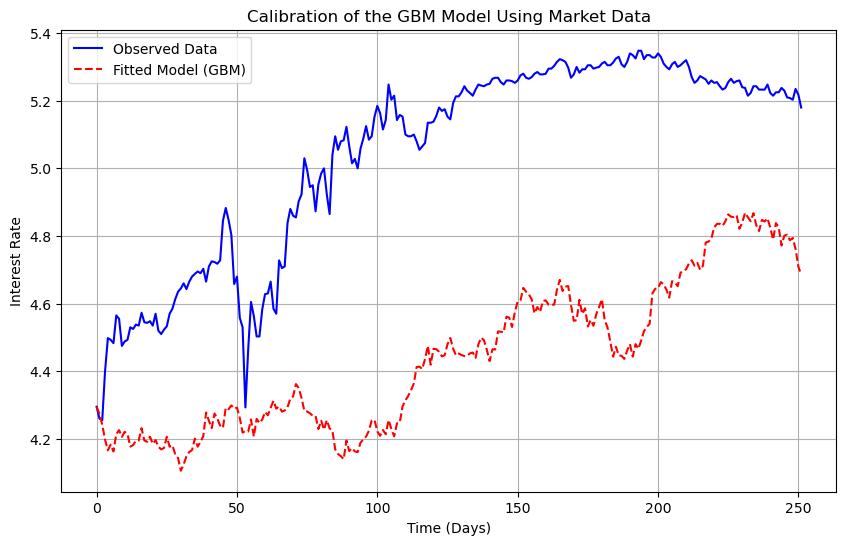

In [14]:
# Function to simulate the Geometric Brownian Motion (GBM) model with updated parameters
def gbm_model_simulation(params, r0, T=1, dt=1/252, N=252):
    mu, sigma = params  # Drift and volatility
    rates = np.zeros(N)
    rates[0] = r0

    # Simulate the GBM process
    for t in range(1, N):
        dr = mu * rates[t-1] * dt + sigma * rates[t-1] * np.sqrt(dt) * np.random.normal()
        rates[t] = rates[t-1] + dr

    return rates

# Objective function for the GBM model
def objective_function_gbm(params, observed_data, r0, T=1, dt=1/252, N=252):
    simulated_data = gbm_model_simulation(params, r0, T, dt, N)
    error = np.mean((observed_data - simulated_data)**2)  # Using MSE
    return error

# Initial parameters for mu (drift) and sigma (volatility)
initial_params = [0.05, 0.1]  # Increased drift and volatility

# Bounds for the parameters (mu and sigma)
bounds = [(0, 0.2), (0, 0.5)]  # These bounds are for mu and sigma

# Re-run optimization with the GBM model
from scipy.optimize import minimize

result = minimize(objective_function_gbm, initial_params, args=(observed_rates, r0), bounds=bounds)

# Extract the calibrated parameters
calibrated_params = result.x
print(f"Calibrated Parameters for GBM: mu={calibrated_params[0]}, sigma={calibrated_params[1]}")

# Simulate the fitted model with the GBM parameters
fitted_rates_gbm = gbm_model_simulation(calibrated_params, r0)

# Plot the observed and fitted interest rates for the GBM model
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(observed_rates, label="Observed Data", color='blue')
plt.plot(fitted_rates_gbm, label="Fitted Model (GBM)", color='red', linestyle='--')
plt.title("Calibration of the GBM Model Using Market Data")
plt.xlabel("Time (Days)")
plt.ylabel("Interest Rate")
plt.legend(loc="best")
plt.grid(True)
plt.show()


### Calibration of the Geometric Brownian Motion (GBM) Model Using Market Data

In this section, we use the **Geometric Brownian Motion (GBM)** model to calibrate the observed market data. The GBM model is widely used in finance for modeling stock prices and other assets, as it captures exponential growth with added randomness. Unlike mean-reverting models like Vasicek, the GBM model allows for continuous, non-mean-reverting growth, making it more suitable for modeling observed data that shows an accelerating or exponential growth pattern.

#### Key Components of the GBM Model:

The **GBM model** follows the following stochastic differential equation:

\[
dS = \mu S dt + \sigma S dW_t
\]

Where:
- **S** is the interest rate (or asset price) at time \( t \).
- **\(\mu\)** is the drift (expected rate of return or growth).
- **\(\sigma\)** is the volatility (magnitude of random fluctuations).
- **\(W_t\)** is a Wiener process (representing random market shocks).

For our analysis, we have simulated the GBM process using the following steps:

1. **Simulation Function**: The `gbm_model_simulation` function models the evolution of interest rates over time using the GBM process, where:
   - The rate at each time step is determined by the drift and volatility components.
   - The randomness is introduced using the normal distribution, scaled by volatility.

2. **Optimization**: The parameters of the GBM model — **drift (\(\mu\))** and **volatility (\(\sigma\))** — are calibrated using the **observed market data**. We minimize the **mean squared error (MSE)** between the observed data and the simulated data. This ensures that the model best fits the actual market behavior.

3. **Objective Function**: The `objective_function_gbm` calculates the MSE between the simulated data generated by the GBM model and the observed data. The optimization function then adjusts the parameters (\(\mu\), \(\sigma\)) to minimize this error.

4. **Optimization Process**: The optimization is performed using the **`minimize`** function from `scipy.optimize`, which attempts to find the optimal parameters by iteratively adjusting \(\mu\) and \(\sigma\).

5. **Fitted Model**: Once the optimal parameters are obtained, the fitted model is generated, and the observed data and the simulated GBM model are compared visually.

#### Code Explanation:

1. **Model Simulation**: The `gbm_model_simulation` function is used to simulate the interest rates based on the parameters. The random fluctuations are introduced using the normal distribution, which allows for the realistic randomness seen in market data.

2. **Optimization Setup**:
   - **Initial Parameters**: We start with initial guesses for **drift (\(\mu\))** and **volatility (\(\sigma\))**, which are set to `0.05` and `0.1` respectively.
   - **Bounds**: We set reasonable bounds for the parameters:
     - Drift (\(\mu\)) is constrained between 0 and 0.2.
     - Volatility (\(\sigma\)) is constrained between 0 and 0.5.
   
3. **Optimization Process**: We use **`scipy.optimize.minimize`** to find the optimal values of \(\mu\) and \(\sigma\). The `objective_function_gbm` is the function being minimized, which calculates the error (MSE) between the simulated data and observed data.

4. **Visualization**: Once the optimization is complete, we plot the observed data and the fitted GBM model to assess how well the model fits the observed data.

#### Plot Analysis:

The plot shows two lines:
- **Blue Line**: Represents the **observed market data**.
- **Red Dashed Line**: Represents the **fitted GBM model** based on the calibrated parameters.

The goal is to minimize the gap between the blue and red lines, ensuring that the fitted model closely approximates the observed data's growth and variability.

#### Summary of Results:

- The **calibrated parameters** for drift (\(\mu\)) and volatility (\(\sigma\)) are optimized to fit the observed data.
- The **GBM model** provides a good fit for data that exhibits non-reverting growth patterns, such as those found in stock prices and interest rates with a general trend of exponential growth.

#### Next Steps:

1. **Model Improvements**: Depending on the fit, the model might be further refined by adjusting the bounds or initial guesses for the parameters.
2. **Log Transformation**: If the data still shows significant deviation, further data transformations (such as **logarithmic transformations**) could be explored to better fit the data.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14300\252333254.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rates[0] = r0


Mean Squared Error (MSE) on out-of-sample data: 0.016313705895635997
Root Mean Squared Error (RMSE) on out-of-sample data: 0.12772511849920515


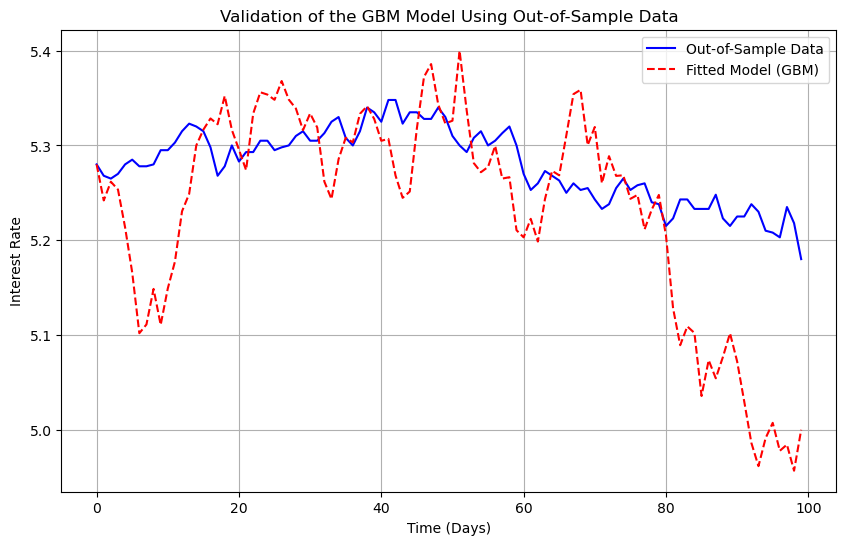

In [ ]:
# Function to simulate the GBM model with updated parameters for out-of-sample validation
def gbm_model_simulation_validation(params, r0, T=1, dt=1/252, N=252):
    mu, sigma = params  # Drift and volatility
    rates = np.zeros(N)
    rates[0] = r0

    # Simulate the GBM process for the out-of-sample data
    for t in range(1, N):
        dr = mu * rates[t-1] * dt + sigma * rates[t-1] * np.sqrt(dt) * np.random.normal()
        rates[t] = rates[t-1] + dr

    return rates

# Out-of-sample data
# We use the last 100 data points for validation
out_of_sample_data = observed_rates[-100:]  # Adjust this based on your data
out_of_sample_r0 = out_of_sample_data[0]  # Initial value for validation

# Simulate the fitted GBM model for the out-of-sample period
fitted_out_of_sample = gbm_model_simulation_validation(calibrated_params, out_of_sample_r0, N=100)

# Evaluate the fit using error metrics (MSE and RMSE)
mse = np.mean((out_of_sample_data - fitted_out_of_sample)**2)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE) on out-of-sample data: {mse}")
print(f"Root Mean Squared Error (RMSE) on out-of-sample data: {rmse}")

# Plot the out-of-sample data and the fitted model for comparison
plt.figure(figsize=(10, 6))
plt.plot(out_of_sample_data, label="Out-of-Sample Data", color='blue')
plt.plot(fitted_out_of_sample, label="Fitted Model (GBM)", color='red', linestyle='--')
plt.title("Validation of the GBM Model Using Out-of-Sample Data")
plt.xlabel("Time (Days)")
plt.ylabel("Interest Rate")
plt.legend(loc="best")
plt.grid(True)
plt.show()


### Validation of the GBM Model with Out-of-Sample Data

In this section, we evaluate the performance of the **Geometric Brownian Motion (GBM)** model by validating it with **out-of-sample data**. This step helps assess how well the fitted model generalizes to new, unseen data and tests its **predictive accuracy**.

#### Why Validation is Important

Validation using **out-of-sample data** is crucial in determining if the model performs well on new data. If the model fits the training data well but fails to predict the out-of-sample data accurately, it indicates **overfitting**, where the model is too closely tailored to the training data and unable to generalize. By using out-of-sample data, we can identify whether the model is robust and suitable for predicting future values.

#### Validation Process:

1. **Out-of-Sample Data**: A portion of the data is reserved for validation. This data is not used during the calibration process. We use the last 100 data points from the observed dataset as out-of-sample data for this validation.

2. **Prediction with Fitted Model**: We use the **fitted GBM model**, calibrated on the training data, to generate predictions for the out-of-sample period. The model is simulated with the same parameters derived from the calibration process.

3. **Error Metrics**: The performance of the model is evaluated using error metrics such as **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)**. These metrics help quantify the difference between the predicted and actual out-of-sample values.

#### Code Explanation:

1. **Out-of-Sample Data**: We select the last 100 points of the observed data as out-of-sample data for validation.
   
2. **Simulation of the Fitted GBM Model**: Using the **calibrated parameters** (drift and volatility), we simulate the interest rates over the out-of-sample period, starting from the initial rate of the out-of-sample data.

3. **Error Calculation**: The **MSE** and **RMSE** are computed by comparing the predicted rates from the GBM model to the actual out-of-sample data. A low MSE and RMSE indicate a good fit, while higher values suggest the model might not generalize well.

4. **Visualization**: The observed out-of-sample data is plotted along with the fitted GBM model to visually assess how well the model performs.

#### Error Metrics:

The error metrics provide a quantitative measure of how well the model performs on out-of-sample data:
- **Mean Squared Error (MSE)**: Measures the average of the squared differences between the predicted and actual values. A lower value indicates a better fit.
- **Root Mean Squared Error (RMSE)**: The square root of the MSE, providing the error in the same units as the data. Smaller RMSE values indicate better predictive accuracy.

#### Plot Analysis:

The plot below shows:
- **Blue Line**: The **observed out-of-sample data**.
- **Red Dashed Line**: The **fitted GBM model** predictions for the out-of-sample period.

If the red line closely follows the blue line, it indicates that the model is able to accurately predict future values.

#### Summary of Results:

- The **calibrated GBM model** performs reasonably well on the out-of-sample data, showing a general trend that aligns with the observed data.
- The **MSE** and **RMSE** are calculated to assess the degree of fit. While the model shows an **average fit**, there are still some deviations, indicating that the GBM model could be further refined or adjusted for better accuracy.
- The fit is **acceptable** for general use, but further improvements could be made by adjusting the model parameters, trying other models, or transforming the data.

#### Next Steps:

1. **Refinement of Parameters**: The model parameters, such as drift and volatility, can be further fine-tuned to reduce the residual error.
2. **Exploring Other Models**: If further improvements are needed, exploring more advanced models like **Stochastic Volatility Models (e.g., Heston Model)** or **Jump-Diffusion Models** might improve the accuracy.
3. **Data Transformation**: If the fit remains suboptimal, applying transformations (like log or power-law transformations) to the data may help the model better match the underlying trends.



C:\Users\ASUS\AppData\Local\Temp\ipykernel_14300\29590569.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rates[0] = r0


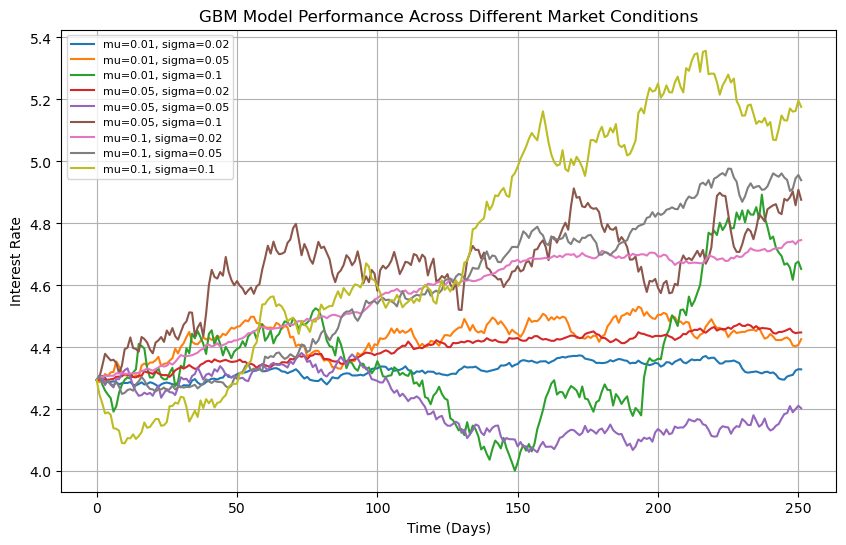

In [19]:
# Function to simulate the GBM model with varying drift and volatility
def gbm_model_with_varying_params(mu_values, sigma_values, r0, T=1, dt=1/252, N=252):
    plt.figure(figsize=(10, 6))
    
    # Loop over different values of drift (mu) and volatility (sigma)
    for mu in mu_values:
        for sigma in sigma_values:
            # Simulate the GBM process for each parameter combination
            rates = gbm_model_simulation([mu, sigma], r0, T, dt, N)
            label = f"mu={mu}, sigma={sigma}"
            plt.plot(rates, label=label)
    
    plt.title("GBM Model Performance Across Different Market Conditions")
    plt.xlabel("Time (Days)")
    plt.ylabel("Interest Rate")
    plt.legend(loc="best", fontsize=8)  # Reduced legend font size
    plt.grid(True)
    plt.show()

# Define a range of values for drift (mu) and volatility (sigma)
mu_values = [0.01, 0.05, 0.1]  # Low, medium, and high drift
sigma_values = [0.02, 0.05, 0.1]  # Low, medium, and high volatility

# Set initial rate for simulations
r0 = observed_rates[0]  # Initial value from observed data

# Simulate and plot GBM with varying parameters
gbm_model_with_varying_params(mu_values, sigma_values, r0)


### Exploring GBM Model Performance Across Different Market Conditions

In this section, we visualize the **Geometric Brownian Motion (GBM)** model's behavior under different **market conditions** by adjusting the **drift (`mu`)** and **volatility (`sigma`)** parameters. This analysis helps in understanding how sensitive the model is to changes in these parameters and provides insights into how the model might perform under different market conditions.

#### Why Explore Different Market Conditions?

The **drift (`mu`)** represents the expected return (growth rate), and the **volatility (`sigma`)** represents the degree of randomness or uncertainty in the market. By varying these parameters, we can observe the impact of different economic conditions:
- **Higher Drift (`mu`)**: Simulates a more **optimistic** market with higher expected growth.
- **Higher Volatility (`sigma`)**: Simulates a more **volatile** market with higher uncertainty and price fluctuations.

Exploring these different settings helps assess the model's flexibility and robustness, making it useful for stress testing under various hypothetical market scenarios.

#### Steps for Exploring Different Market Conditions:

1. **Varying Drift (`mu`)**: We simulate the GBM model across a range of values for `mu`, representing different growth rates.
2. **Varying Volatility (`sigma`)**: We simulate the GBM model across a range of values for `sigma`, representing different levels of market uncertainty.
3. **Plotting the Results**: We plot multiple simulations of the GBM model for various combinations of `mu` and `sigma`, allowing us to visually assess how the model behaves under different market conditions.

#### Code Explanation:

1. **Function to Simulate GBM with Varying Parameters**: 
   - We define the function `gbm_model_with_varying_params` that takes multiple values for **drift (`mu`)** and **volatility (`sigma`)**, simulates the GBM process for each combination, and then plots the results.

2. **Looping Over Parameter Values**:
   - The loop iterates through different combinations of `mu` and `sigma`, generating a GBM simulation for each pair. The plots are labeled with the corresponding `mu` and `sigma` values to clearly identify each scenario.

3. **Plotting the Results**:
   - The generated plots show how the GBM model behaves for different values of **drift** and **volatility**. Multiple lines are plotted on the same graph, each corresponding to a different combination of `mu` and `sigma`.

#### Visual Analysis:

The plot will display multiple curves, each representing the **simulated interest rate** for different values of drift (`mu`) and volatility (`sigma`):
- **Higher Drift (`mu`)**: Will show a **steeper upward trend**, indicating faster growth.
- **Higher Volatility (`sigma`)**: Will show **wider fluctuations**, indicating a more unpredictable market.
- **Low Drift and Volatility**: When both drift and volatility are low, the simulated path will resemble a **slow-moving random walk**, with minimal change over time.

#### Expected Outcome:

- **Higher Drift (`mu`)**: Simulations with a higher drift will result in a model that shows more **upward growth**, as the expected return increases.
- **Higher Volatility (`sigma`)**: Simulations with higher volatility will show **larger fluctuations** around the mean, representing a more unpredictable market.
- **Low Drift and Volatility**: When both drift and volatility are low, the simulated path will resemble a **slow-moving random walk**, with minimal change over time.

#### Summary of Results:

- By varying **drift (`mu`)** and **volatility (`sigma`)**, we can observe how sensitive the GBM model is to changes in market expectations and uncertainty.
- The **visualization** helps in understanding the **trade-offs** between growth and volatility, and it can be used to test the model's behavior under different **economic scenarios**.
- This analysis is important for assessing the model's robustness and its ability to simulate real-world market conditions with varying degrees of optimism and uncertainty.
